In [1]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-tgrjk2qt
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-tgrjk2qt
  Resolved https://github.com/facebookresearch/detectron2.git to commit 400a49c1ec11a18dd25aea3910507bc3bcd15794
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.6 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Current device: cuda:0
Selected image path: /content/drive/MyDrive/BMI Photos/SMA563_Week 10 (1).jpg
Test image path: /content/drive/MyDrive/BMI Photos/SMA563_Week 10 (1).jpg


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


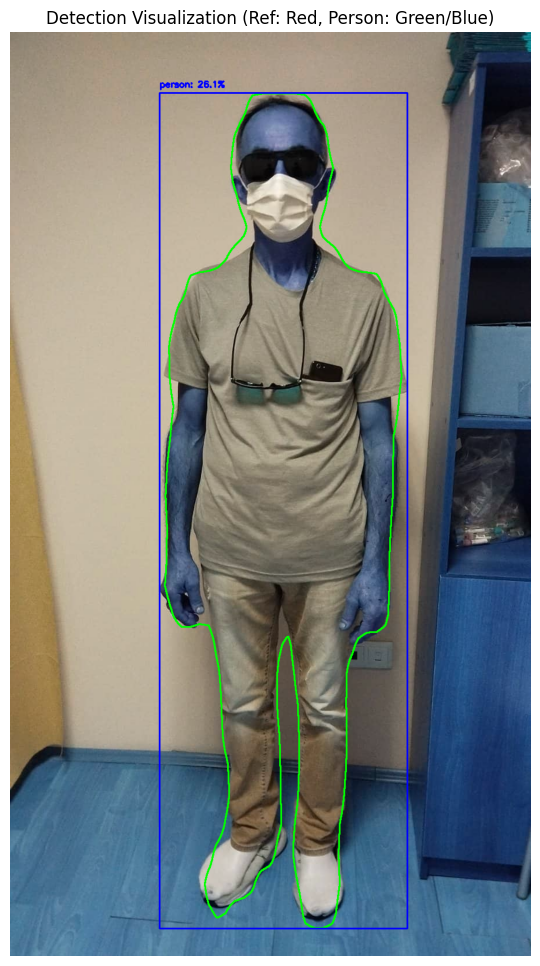

Reference Detection Results:
  No reference objects detected

Human Detection Results:
  Label: person, Score: 0.9996, Area Ratio: 26.12%


In [2]:
import os
import random
import json
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from dataclasses import dataclass
from typing import List, Dict, Optional, Union, Tuple

import torch
from transformers import pipeline

# Global device setting
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current device:", DEVICE)

# Load Detectron2 model for human detection
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Detection threshold
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
person_predictor = DefaultPredictor(cfg)

# Load Grounding Dino model for reference object detection (without SAM)
def detect_ref_objects(
    image: Union[Image.Image, str],
    labels: List[str],
    threshold: float = 0.7,
    detector_id: Optional[str] = None
) -> Tuple[np.ndarray, List['DetectionResult']]:
    if isinstance(image, str):
        image = Image.open(image).convert("RGB")
    image = ImageOps.exif_transpose(image)
    labels = [lb if lb.endswith('.') else lb + '.' for lb in labels]
    # Create a new pipeline for each call (could be globalized)
    detector_local = pipeline(
        model=detector_id if detector_id is not None else "IDEA-Research/grounding-dino-tiny",
        task="zero-shot-object-detection",
        device=0 if torch.cuda.is_available() else -1
    )
    results = detector_local(image, candidate_labels=labels, threshold=threshold)
    detections = [DetectionResult.from_dict(r) for r in results]
    return np.array(image), detections

# Define data structures
@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.ndarray] = None  # SAM is not used, so mask can be empty

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        return cls(
            score=detection_dict['score'],
            label=detection_dict['label'],
            box=BoundingBox(
                xmin=int(detection_dict['box']['xmin']),
                ymin=int(detection_dict['box']['ymin']),
                xmax=int(detection_dict['box']['xmax']),
                ymax=int(detection_dict['box']['ymax'])
            )
        )

# Human detection function using Detectron2
def detect_human(image: Image.Image) -> List[DetectionResult]:
    """
    Detect humans in the input image and return the detection results.
    It tries to use the mask for finer visualization.
    """
    image_np = np.array(image)
    img_cv = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    outputs = person_predictor(img_cv)
    instances = outputs["instances"]
    detections = []
    if len(instances) > 0:
        person_idxs = (instances.pred_classes == 0).nonzero().squeeze()
        if person_idxs.numel() > 0:
            if person_idxs.ndim == 0:
                idx = person_idxs.item()
            else:
                scores = instances.scores[person_idxs]
                idx = person_idxs[scores.argmax()]
            bbox = instances.pred_boxes[idx].tensor.cpu().numpy()[0]
            # Use the mask if available and convert it to uint8
            if instances.has("pred_masks"):
                mask = instances.pred_masks[idx].cpu().numpy().astype(np.uint8)
            else:
                mask = None
            det = DetectionResult(
                score=float(instances.scores[idx]),
                label="person",
                box=BoundingBox(xmin=int(bbox[0]), ymin=int(bbox[1]), xmax=int(bbox[2]), ymax=int(bbox[3])),
                mask=mask
            )
            detections.append(det)
    return detections

# Visualization function: shows both reference objects and human detections
def visualize_detections_all(image_path: str, ref_labels: List[str]) -> None:
    """
    Load the image from image_path, perform reference object detection with Grounding Dino
    and human detection with Detectron2. Visualize as follows:
      - Reference objects are shown with red boxes (displaying area ratio).
      - Human detections, if a mask is available, are shown with contour lines (green), otherwise with bounding boxes.
    """
    image = Image.open(image_path).convert("RGB")
    image = ImageOps.exif_transpose(image)
    W, H = image.size

    # Reference object detection
    img_np_ref, ref_dets = detect_ref_objects(image, ref_labels, threshold=0.7, detector_id="IDEA-Research/grounding-dino-tiny")
    # Human detection
    human_dets = detect_human(image)

    # Copy image for display
    img_display = img_np_ref.copy()

    # Draw reference objects (red)
    for det in ref_dets:
        box = det.box.xyxy
        bbox_area = (box[2]-box[0])*(box[3]-box[1])
        area_ratio = bbox_area / (W * H)
        cv2.rectangle(img_display, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
        cv2.putText(img_display, f"{det.label}: {area_ratio*100:.1f}%", (box[0], box[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Draw human detections
    for det in human_dets:
        box = det.box.xyxy
        if det.mask is not None and det.mask.size > 0:
            # Convert mask to a proper 2D array with the same size as the image
            mask = np.squeeze(det.mask)
            if mask.ndim != 2:
                mask = mask[..., 0]
            if mask.shape != (H, W):
                mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)
            # Find contours and draw them (green)
            mask_uint8 = (mask * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(img_display, contours, -1, (0, 255, 0), 2)
            human_area = float(np.sum(mask))
        else:
            human_area = (box[2]-box[0])*(box[3]-box[1])
        area_ratio = human_area / (W * H)
        cv2.rectangle(img_display, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
        cv2.putText(img_display, f"person: {area_ratio*100:.1f}%", (box[0], box[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Convert image to RGB for display
    img_display_rgb = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 12))
    plt.imshow(img_display_rgb)
    plt.axis("off")
    plt.title("Detection Visualization (Ref: Red, Person: Green/Blue)")
    plt.show()

    # Print detailed detection results
    print("Reference Detection Results:")
    if not ref_dets:
        print("  No reference objects detected")
    else:
        for det in ref_dets:
            box = det.box.xyxy
            bbox_area = (box[2]-box[0])*(box[3]-box[1])
            area_ratio = bbox_area / (W * H)
            print(f"  Label: {det.label}, Score: {det.score:.4f}, Area Ratio: {area_ratio*100:.2f}%")
    print("\nHuman Detection Results:")
    if not human_dets:
        print("  No humans detected")
    else:
        for det in human_dets:
            box = det.box.xyxy
            if det.mask is not None and det.mask.size > 0:
                mask = np.squeeze(det.mask)
                if mask.ndim != 2:
                    mask = mask[..., 0]
                if mask.shape != (H, W):
                    mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)
                human_area = float(np.sum(mask))
            else:
                human_area = (box[2]-box[0])*(box[3]-box[1])
            area_ratio = human_area / (W * H)
            print(f"  Label: {det.label}, Score: {det.score:.4f}, Area Ratio: {area_ratio*100:.2f}%")

# Main program: randomly select an image for detection and visualization
if __name__ == "__main__":
    SAMPLE_JSON = "/content/drive/MyDrive/sample_list.json"
    with open(SAMPLE_JSON, "r") as f:
        samples = json.load(f)

    sample = random.choice(samples)
    test_image_path = random.choice(sample["img_paths"])
    print("Selected image path:", test_image_path)
    if not os.path.exists(test_image_path):
        raise ValueError(f"Image file does not exist: {test_image_path}")
    print("Test image path:", test_image_path)

    ref_labels = ["a white ball.", "a dark paper."]
    visualize_detections_all(test_image_path, ref_labels)
